In [1]:
#Import required function
import numpy as np
from scipy.interpolate import interp1d
import h5py
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
%matplotlib inline

First import uncleaned data from Hanford during O1.

time = 4096  nsamples = 16777216  sample rate = 4096


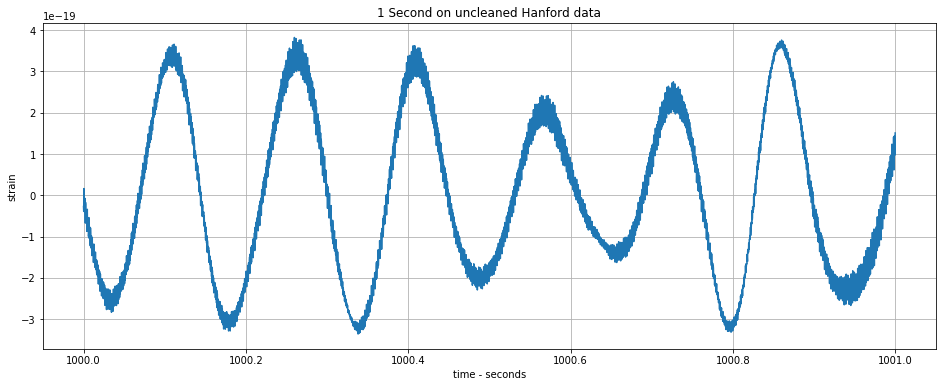

In [2]:
#Read a peice of strain data and make a time vector
filename = '../Data/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
f = h5py.File(filename, 'r')
strain = f['strain/Strain'][()]
dt = f['strain/Strain'].attrs['Xspacing']
tstart = f['meta/GPSstart'][()]
tend = f['meta/Duration'][()] + tstart
f.close()

#Create a time vector starting at 0, and get the sampling frequency
ts = np.arange(0, tend-tstart, dt)
fs = int(1/dt)
print('time =', (tend - tstart), ' nsamples =', len(strain), ' sample rate =', fs)

#Plot 1 second of strain data
plt.figure(figsize=(16, 6))
plt.plot(ts[1000*fs:1001*fs], strain[1000*fs:1001*fs])
plt.title('1 Second on uncleaned Hanford data')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

Next generate a waveform of known parameters to input into the data for matched filtering

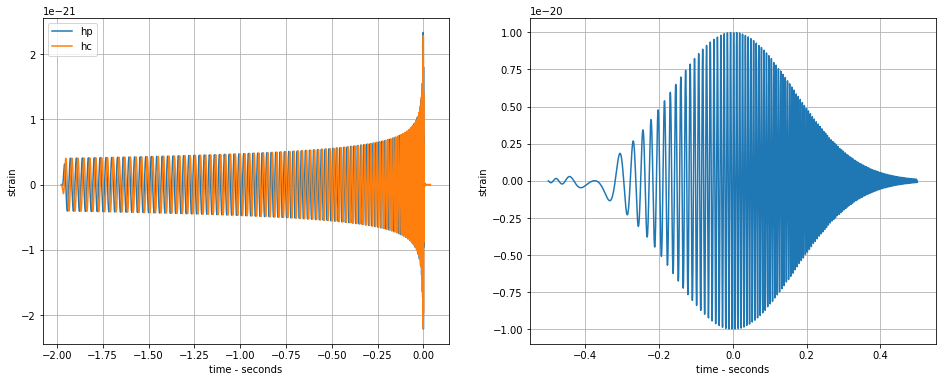

In [3]:
def Hann(n, N):
    """Evalute a Hann window of length N at point n"""
    y = 0.5*(1-np.cos(2*np.pi*n/(N-1)))
    return y


def SGsignal(length, freq, freqm, max_amp):
    """Define function that takes the required length in samples, the required freq in samples,
    the the gradient at which the frequency should increase and the max amplitude
    Return a sine function with frequency increasing with time to freq*freqm,
    starting at freq, multiplied by a gaussian with SD of length/6"""
    sd = length/6
    x = np.arange(length) - (length-length%2)/2.
    k = 2*np.pi*freq * np.linspace(1, freqm, num=length)
    y = max_amp * np.exp(-(x**2)/(2*(sd**2))) * np.sin(k*x)
    return x, y


#Use pycbc to produce waveform, then convert to numpy array and smooth turn on
hp0, hc0 = get_td_waveform(approximant="SEOBNRv4_opt", mass1=10, mass2=10, delta_t=dt, f_lower=30, distance = 100)
hp = hp0.numpy()
hp[:100] *= Hann(np.arange(100), 200)
hc = hc0.numpy()
hc[:100] *= Hann(np.arange(100), 200)
ht = hp0.sample_times.numpy()

#Create a fake transient signal with high strain amplitude to test RSNR
lengths_fake = 1 #length of signal in seconds
freqs_fake = 40. #freq in seconds^-1
length_fake, freq_fake, freqm_fake, maxa_fake = int(lengths_fake*fs), freqs_fake/fs, 5, 1e-20
x_fake, y_fake = SGsignal(length_fake, freq_fake, freqm_fake, maxa_fake)

#Plot both polarisations and the fake signal
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ht, hp, label='hp')
plt.plot(ht, hc, label='hc')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x_fake*dt, y_fake)
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

Next imput signal into data

Event time = 770.36376953125
Fake time = 1722.5625


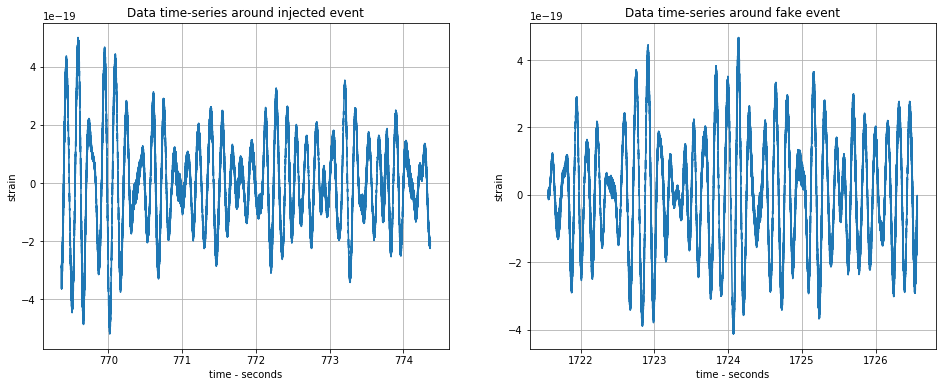

In [4]:
#Place data within noise
eventi = int( np.random.rand(1) * (len(strain) - len(ht)) )
eventt = eventi*dt
data = np.zeros((len(strain)), dtype='float')
data[eventi:eventi+len(ht)] += hp
data += strain
print('Event time =', eventt)

#Place fake signal within noise
fakei = int( np.random.rand(1) * (len(strain) - len(y_fake)) )
faket = fakei*dt
data[fakei:fakei+len(y_fake)] += y_fake
print('Fake time =', faket)

#Plot new data time series around event
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ts[eventi-fs:eventi+fs*4], strain[eventi-fs:eventi+fs*4])
plt.title('Data time-series around injected event')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(ts[fakei-fs:fakei+fs*4], strain[fakei-fs:fakei+fs*4])
plt.title('Data time-series around fake event')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

Now calculate the psd of the data using Welch's method, then whiten the data (whitened data won't be used in the match filtering, doing this purely for inspection).

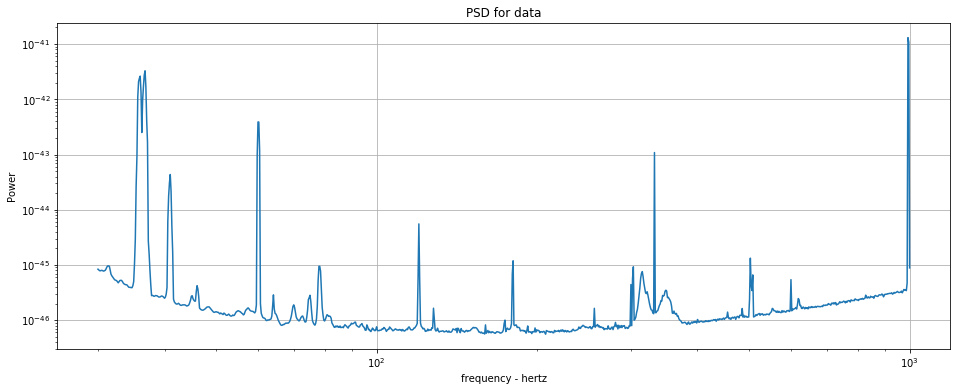

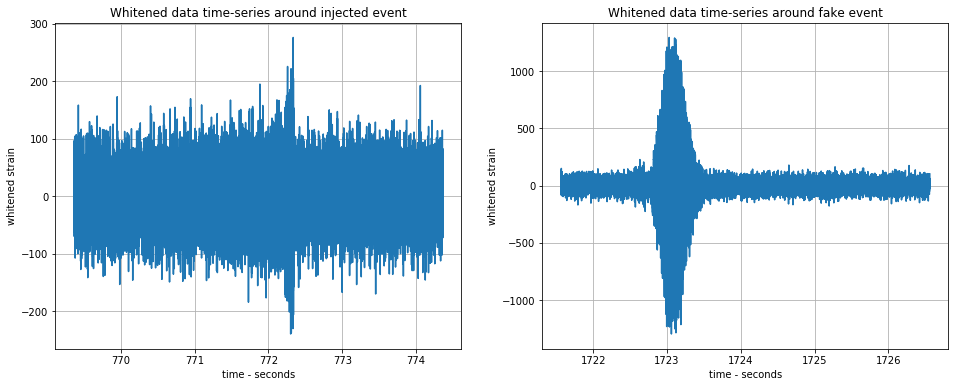

In [5]:
def calcpsd(x, y, windowl, window):
    """Calculate the PSD from the signal time series averaged from the PSDs of length windowl.
    Use given window to smooth each fft. Return the PSD as an interpolated function.
    Median correction term defined in FINDCHIRP paper."""
    dx = x[1] - x[0]
    neach = int(windowl/dx)
    nfft = int(2 * len(y)//neach - 1)
    shift = int(np.ceil(neach/2))
    freq = np.fft.rfftfreq(neach, dx)
    asds = np.zeros((nfft, len(freq)), dtype='complex')
    psds = np.zeros((nfft, len(freq)), dtype='complex')
    mask = window(np.arange(neach), neach)
    for i in range(0, nfft):
        windowed = y[i*shift:i*shift + neach]*mask
        asds[i, :] = np.fft.rfft(windowed)*dx
        psds[i, :] = 2*(freq[1]-freq[0])*asds[i, :]*np.conj(asds[i, :])/(np.sum(mask**2)/neach)
    if nfft%2 == 0:
        median_correction = 1
    else:
        median_correction = np.sum(np.power(-1.*np.ones(nfft), np.arange(nfft)+2)/(np.arange(nfft)+1))
    psd = np.median(psds, axis=0)/median_correction
    psdi = interp1d(freq, np.real(psd), axis=0, bounds_error=False, fill_value=0)
    return psdi


def whiten(x, y, psd0):
    """use interpolated psd to whiten given data"""
    dx = x[1] - x[0]
    num = np.size(x)
    fs = int(1/dx)
    freqs = np.fft.rfftfreq(num, dx)
    yft = np.fft.rfft(y)*dx
    white_yft = yft/np.sqrt(psd0(freqs))
    white_y = np.fft.irfft(white_yft)*(freqs[1]-freqs[0])*num
    return np.real(white_y)


#Apply functions to data to find psd and whiten data
psdcut = 4    #Length in seconds of the window used in Welch's method and truncation
psdi = calcpsd(ts, data, psdcut, Hann)
white_strain = whiten(ts, data, psdi)

#Plot PSD evaluated from 30 to 500Hz
fplot = np.geomspace(30, 1000, num=1000, endpoint=True)
plt.figure(figsize=(16, 6))
plt.plot(fplot, psdi(fplot))
plt.xscale('log')
plt.yscale('log')
plt.title('PSD for data')
plt.xlabel('frequency - hertz')
plt.ylabel('Power')
plt.grid()

#Plot whitened data around event
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ts[eventi-fs:eventi+fs*4], white_strain[eventi-fs:eventi+fs*4])
plt.title('Whitened data time-series around injected event')
plt.xlabel('time - seconds')
plt.ylabel('whitened strain')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(ts[fakei-fs:fakei+fs*4], white_strain[fakei-fs:fakei+fs*4])
plt.title('Whitened data time-series around fake event')
plt.xlabel('time - seconds')
plt.ylabel('whitened strain')
plt.grid()

Next the psd must be inverted, inverse fourier transformed, truncated and fourier transformed to reduce the impulse response of the matched filter.

In [6]:
def itrunc_psd(psdi, psdcut, datax):
    """inverts and trucates the psd for use in matched filtering.
    Evaluate the psd at the resolution of the data and invert it.
    Then inverse fourier transform the result and truncate to psdcut.
    Finally fourier transform this back to the frequency domain."""
    dx = datax[1]-datax[0]
    fs = int(1/dx)
    freqs = np.fft.rfftfreq(len(datax), dx)
    inv_asd = 1/psdi(freqs)**0.5
    inv_asd_t = np.fft.irfft(inv_asd)*(freqs[1]-freqs[0])*len(datax)
    #inv_asd_t[int(np.ceil(psdcut*fs/2)):int(np.floor(-psdcut*fs/2))] *= 0
    inv_asd_tcut = np.concatenate((inv_asd_t[:int(np.ceil(psdcut*fs/2))], inv_asd_t[int(np.floor(-psdcut*fs/2)):]))
    itrunc_f = np.fft.rfftfreq(psdcut*fs, dx)
    itrunc_a = np.fft.rfft(inv_asd_tcut)*dx
    itrunc = interp1d(itrunc_f, itrunc_a*np.conj(itrunc_a), axis=0, bounds_error=False, fill_value=0)
    return itrunc


it_psd = itrunc_psd(psdi, psdcut, ts)

The basic SNR time-series can now be calculated

/home/mcisaacc/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Max SNR at t = 1721.0911670381527 
Event missed by t = 950.7273975069027     Fake missed by t = 1.471332961847338


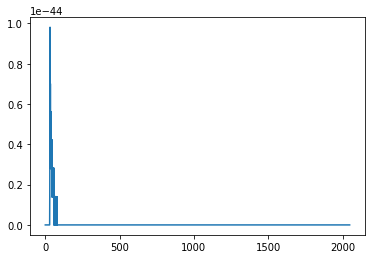

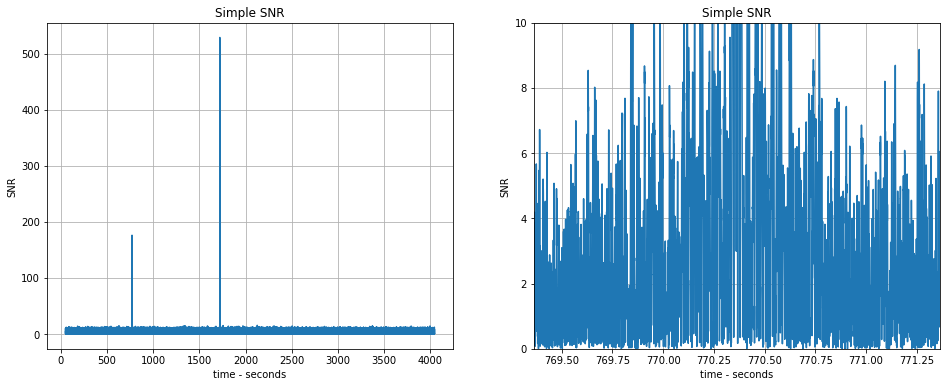

In [7]:
def calcsnr(xdata, ydata, xtemp, ytemp, it_psd):
    """Perform the inner product of two signals given in the time domain
    return the resulting time-series scaled to snr. Assuming the resolutions are equal"""
    dx = xdata[1] - xdata[0]
    if len(ydata) < len(ytemp):
        xft = np.fft.rfftfreq(len(xtemp), dx)
        y2ft = np.fft.rfft(ytemp)*dx
        y1 = np.zeros((len(xtemp)), dtype='float')
        y1[:len(ydata)] += ydata
        y1ft = np.fft.rfft(y1)*dx
    elif len(ytemp) < len(ydata):
        xft = np.fft.rfftfreq(len(xdata), dx)
        y1ft = np.fft.rfft(ydata)*dx
        y2 = np.zeros((len(xdata)), dtype='float')
        y2[:len(ytemp)] += ytemp
        y2ft = np.fft.rfft(y2)*dx
    else:
        xft = np.fft.rfftfreq(len(xdata), dx)
        y1ft = np.fft.rfft(ydata)*dx
        y2ft = np.fft.rfft(ytemp)*dx
    y3ft = it_psd(xft)
    innerft = y1ft*np.conj(y2ft)*y3ft
    yinner0 = np.fft.irfft(innerft)*(xft[1]-xft[0])*len(xdata)
    yinner = np.real(4*(yinner0*np.conj(yinner0))**0.5)
    norm0 = y2ft*np.conj(y2ft)*y3ft
    plt.figure()
    plt.plot(xft, y2ft*np.conj(y2ft))
    norm = np.real(4*np.sum(norm0*(xft[1]-xft[0])))
    snr = yinner/np.sqrt(norm)
    dt = 1/(len(snr)*(xft[1] - xft[0]))
    xsnr = np.linspace(0, len(snr)*dt, num=len(snr))
    return xsnr, snr


tsnr0, snr0 = calcsnr(ts, data, ht, hp, it_psd)
tsnr = tsnr0[50*fs:-50*fs]
snr = snr0[50*fs:-50*fs]
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(tsnr, snr)
plt.title('Simple SNR')
plt.xlabel('time - seconds')
plt.ylabel('SNR')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tsnr, snr)
plt.xlim([eventt-1, eventt+1])
plt.ylim([0, 10])
plt.title('Simple SNR')
plt.xlabel('time - seconds')
plt.ylabel('SNR')
plt.grid()

print('Max SNR at t =', tsnr[np.argmax(snr)], '\nEvent missed by t =', np.abs(eventt-tsnr[np.argmax(snr)]),
     '    Fake missed by t =', np.abs(faket-tsnr[np.argmax(snr)]))

Next apply a chi squared statistic by binning the template into bins of equal power and comparing the SNR of each with the data to the expected SNR.

/home/mcisaacc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

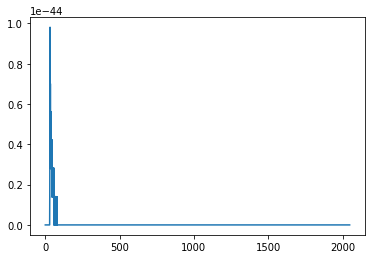

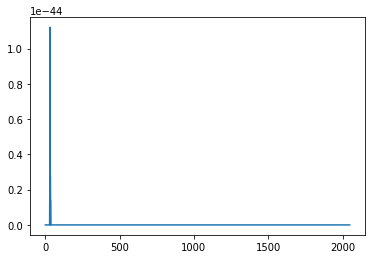

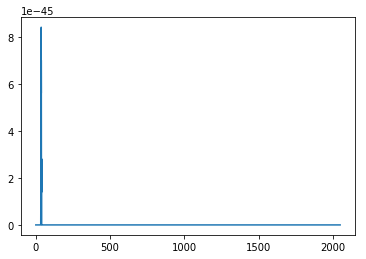

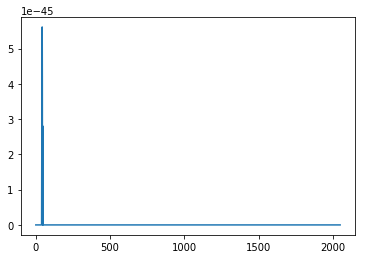

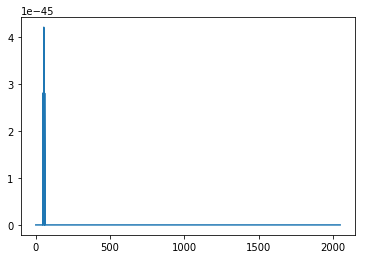

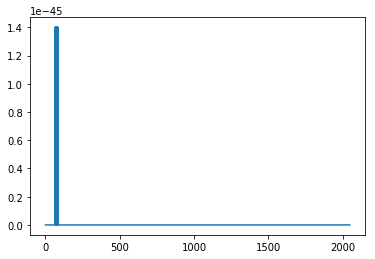

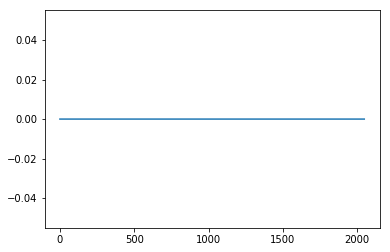

In [8]:
def chi_squared(xdata, ydata, xtemp, ytemp, it_psd, nbins):
    templates = np.zeros((len(xtemp), nbins), dtype='float')
    power = sum(ytemp**2)
    used = 0
    pbins = np.zeros((nbins), dtype='float')
    for i in range(0, nbins-1):
        pbin = 0
        count = 0
        while pbin < power/nbins:
            templates[used+count, i] = ytemp[used+count]
            pbin += ytemp[used+count]**2
            count += 1
        used += count
        pbins[i] = pbin
    templates[used:, -1] = ytemp[used:]
    plt.figure()
    pbins[-1] = sum(ytemp[used:]**2)
    x0, snr0 = calcsnr(xdata, ydata, xtemp, ytemp, it_psd)
    x = x0[50*fs:-50*fs]
    snr = snr0[50*fs:-50*fs]
    psnr = np.zeros((len(snr), nbins), dtype='float')
    for i in range(0, nbins):
        _, psnr0 = calcsnr(xdata, ydata, xtemp, templates[:, i], it_psd)
        psnr[:, i] = np.abs(psnr0[50*fs:-50*fs])
    chi_each = np.zeros((len(snr), nbins), dtype='float')
    for i in range(0, nbins):
        chi_each[:, i] = (psnr[:, i] - snr*(pbins[i]/power))**2
    chi = np.sum(chi_each, axis=1)
    rsnr = np.zeros((len(snr)), dtype='float')
    for i in range(0, len(snr)):
        if chi[i] > 1:
            rsnr[i] = snr[i]/(((1 + chi[i]**3)/2.)**(1/6.))
        else:
            rsnr[i] = snr[i]
    return x, snr, chi, rsnr


tchi0, chisnr0, chi0, rsnr0 = chi_squared(ts, data, ht, hp, it_psd, 6)
tchi = tchi0[50*fs:-50*fs]
chisnr = 4*chisnr0[50*fs:-50*fs]
chi = chi0[50*fs:-50*fs]
rsnr = rsnr0[50*fs:-50*fs]
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(tchi, chi)
plt.title('Chi Squared Test')
plt.xlabel('time - seconds')
plt.ylabel('chi squared')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tchi, chi)
plt.xlim([eventt-.1, eventt+.1])
plt.ylim([0, 2])
plt.title('Chi Squared Test')
plt.xlabel('time - seconds')
plt.ylabel('chi squared')
plt.grid()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(tchi, rsnr)
plt.title('Reduced SNR')
plt.xlabel('time - seconds')
plt.ylabel('RSNR')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tchi, rsnr)
plt.xlim([eventt-1, eventt+1])
plt.title('Reduced SNR')
plt.xlabel('time - seconds')
plt.ylabel('SNR')
plt.grid()

print('Max RSNR at t =', tchi[np.argmax(rsnr)], '\nEvent missed by t =', np.abs(eventt-tchi[np.argmax(rsnr)]),
     '    Fake missed by t =', np.abs(faket-tchi[np.argmax(rsnr)]))

The Chi-squared statistic helps reduced the transient signifigance.